In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense,  Conv2D, MaxPooling2D, TimeDistributed, Flatten, InputLayer, Reshape, Conv1D, MaxPooling1D, Bidirectional, Dropout, ReLU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adadelta, SGD, Adagrad
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.metrics import r2_score
import random
from datetime import datetime, timedelta
import math

#%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


random.seed(1)

Found GPU at: /device:GPU:0


In [2]:
print(tf.version.VERSION)

2.9.1


In [3]:
columns = ['Date/Time','DistrictCooling:Facility [J](Hourly)', 'DistrictHeating:Facility [J](Hourly)','InteriorLights:Electricity [J](Hourly)',
           'ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXOFFICE:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXOFFICE:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
           'Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)',
           'Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly)',
           'Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly)',
           'Environment:Site Wind Speed [m/s](Hourly)',
           'Environment:Site Wind Direction [deg](Hourly)',
           'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly)',
           'Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly)',
           'Environment:Site Solar Azimuth Angle [deg](Hourly)',
           'Environment:Site Solar Altitude Angle [deg](Hourly)',]


In [4]:
def extract_columns_from_csv(file_name):
    # file_name = 'data/sim_2018.csv'
    df = pd.read_csv(file_name)
    new_df = pd.DataFrame(df, columns=columns)

    new_df['DistrictCooling:Facility [J](Hourly)'] = new_df['DistrictCooling:Facility [J](Hourly)']/3.6e6
    new_df['DistrictHeating:Facility [J](Hourly)'] = new_df['DistrictHeating:Facility [J](Hourly)']/3.6e6
    new_df['InteriorLights:Electricity [J](Hourly)'] = new_df['InteriorLights:Electricity [J](Hourly)']/3.6e6
    new_df['Temp_IN'] = new_df[['ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXOFFICE:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXOFFICE:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE4:Zone Operative Temperature [C](Hourly:ON)']].mean(1)

    new_df['Heating setpoint'] = 21
    new_df['Heating setpoint'][24*134:24*257] = 0
    new_df['Cooling setpoint'] = 24
    new_df['Cooling setpoint'][:24*104] = 0
    new_df['Cooling setpoint'][24*287:] = 0
    new_df.head()
    plot_cooling_heating_lights(new_df, file_name)
    return new_df


In [5]:
def plot_cooling_heating_lights(df, file_name):
    # df is dataframe
    plt.figure()
    plt.title(file_name)
    df['DistrictCooling:Facility [J](Hourly)'].plot()
    df['DistrictHeating:Facility [J](Hourly)'].plot()
    df['InteriorLights:Electricity [J](Hourly)'].plot()
    plt.show()

In [8]:
def change_date_format(df):
    ts = []
    for item in df['Date/Time']:
        temp = item
        splitted = temp.split(' ')
        try:
            date = splitted[1]
            time = splitted[3]
        except Exception as e:
            date = splitted[0]
            time = splitted[2]
        if (time == '24:00:00'):
            time = '00:00:00'
        timestamp = datetime.strptime(f'{date}/2019 {time}', '%m/%d/%Y %H:%M:%S')
        if (time == '00:00:00'):
            timestamp += timedelta(days=1)
        ts.append(timestamp)
    df['Date/Time'] = pd.to_datetime(ts, format='%m/%d/%Y %H:%M:%S')
    return df

In [22]:
def separate_date(df):
    days = []
    months = []
    years = []
    hours = []
    minutes = []
    for timestamp in df['Date/Time']:
        days.append(timestamp.day)
        months.append(timestamp.month)
        years.append(timestamp.year)
        hours.append(timestamp.hour)
        minutes.append(timestamp.minute)

    X_train = pd.DataFrame()
    X_train['day'] = days
    X_train['month'] = months
    X_train['year'] = years
    X_train['hour'] = hours
    X_train['minute'] = minutes
    X_train.index = df.index
    return X_train

C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setp

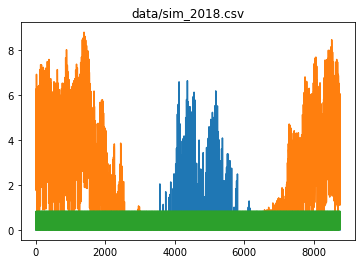

C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setp

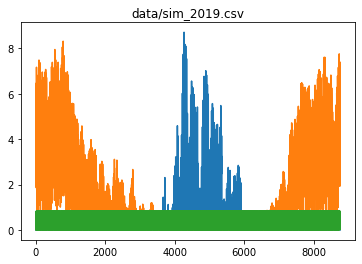

C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setp

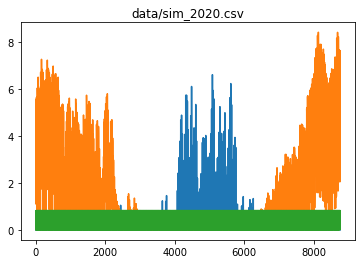

C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_1668/2863304330.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setp

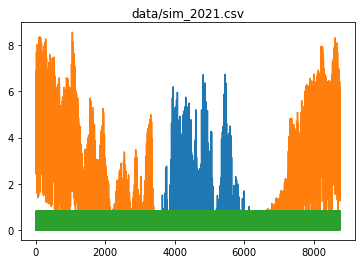

In [6]:
dff_sim_2018 = extract_columns_from_csv('data/sim_2018.csv')
dff_sim_2019 = extract_columns_from_csv('data/sim_2019.csv')
dff_sim_2020 = extract_columns_from_csv('data/sim_2020.csv')
dff_sim_2021 = extract_columns_from_csv('data/sim_2021.csv')

In [9]:
dff_sim_2019.head()

,Date/Time,DistrictCooling:Facility [J](Hourly),DistrictHeating:Facility [J](Hourly),InteriorLights:Electricity [J](Hourly),ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON),...,Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](Hourly),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Solar Azimuth Angle [deg](Hourly),Environment:Site Solar Altitude Angle [deg](Hourly),Temp_IN,Heating setpoint,Cooling setpoint
0,01/01 01:00:00,0.0,3.663996,0.0,0.200793,17.419675,15.071906,16.343224,16.270164,18.643704,...,95112.083333,0.353897,309.21875,0.0,0.0,9.218535,-67.993246,15.794059,21,0
1,01/01 02:00:00,0.0,3.638940,0.0,0.184688,17.040108,14.977388,16.295728,16.208288,18.662007,...,95145.000000,0.430264,246.40625,0.0,0.0,34.159499,-64.819077,15.705852,21,0
2,01/01 03:00:00,0.0,3.748993,0.0,0.285083,16.892293,14.907208,16.257274,16.165384,18.673387,...,95145.000000,0.566855,230.46875,0.0,0.0,58.222105,-57.144973,15.670757,21,0
3,01/01 04:00:00,0.0,3.856684,0.0,0.260363,16.767475,14.851601,16.224721,16.129769,18.682285,...,95145.000000,0.359795,289.21875,0.0,0.0,74.474857,-47.428622,15.631796,21,0
4,01/01 05:00:00,0.0,3.929555,0.0,0.099079,16.667777,14.806129,16.196781,16.099621,18.689987,...,95145.000000,0.065191,306.25000,0.0,0.0,86.722817,-36.964427,15.587676,21,0


In [10]:
dff_sim_2018 = change_date_format(dff_sim_2018)
dff_sim_2019 = change_date_format(dff_sim_2019)
dff_sim_2020 = change_date_format(dff_sim_2020)
dff_sim_2021 = change_date_format(dff_sim_2021)
dff_sim_2019.head()

,Date/Time,DistrictCooling:Facility [J](Hourly),DistrictHeating:Facility [J](Hourly),InteriorLights:Electricity [J](Hourly),ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON),...,Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](Hourly),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Solar Azimuth Angle [deg](Hourly),Environment:Site Solar Altitude Angle [deg](Hourly),Temp_IN,Heating setpoint,Cooling setpoint
0,2019-01-01 01:00:00,0.0,3.663996,0.0,0.200793,17.419675,15.071906,16.343224,16.270164,18.643704,...,95112.083333,0.353897,309.21875,0.0,0.0,9.218535,-67.993246,15.794059,21,0
1,2019-01-01 02:00:00,0.0,3.638940,0.0,0.184688,17.040108,14.977388,16.295728,16.208288,18.662007,...,95145.000000,0.430264,246.40625,0.0,0.0,34.159499,-64.819077,15.705852,21,0
2,2019-01-01 03:00:00,0.0,3.748993,0.0,0.285083,16.892293,14.907208,16.257274,16.165384,18.673387,...,95145.000000,0.566855,230.46875,0.0,0.0,58.222105,-57.144973,15.670757,21,0
3,2019-01-01 04:00:00,0.0,3.856684,0.0,0.260363,16.767475,14.851601,16.224721,16.129769,18.682285,...,95145.000000,0.359795,289.21875,0.0,0.0,74.474857,-47.428622,15.631796,21,0
4,2019-01-01 05:00:00,0.0,3.929555,0.0,0.099079,16.667777,14.806129,16.196781,16.099621,18.689987,...,95145.000000,0.065191,306.25000,0.0,0.0,86.722817,-36.964427,15.587676,21,0


In [14]:
df_train = pd.concat([dff_sim_2018, dff_sim_2019, dff_sim_2020], axis=0)
df_train.reset_index(drop=True, inplace=True)
df_test = dff_sim_2021

In [15]:
regressands = [
      'Temp_IN'
]
features = [
    'Temp_IN',
]

SINGLE RUN OF THE MODEL

In [16]:
X_train = separate_date(df_train)

X_train = X_train.join(df_train[np.concatenate((features, regressands))])
X_train.describe()

,day,month,year,hour,minute,Temp_IN,Temp_IN
count,26280.000000,26280.000000,26280.000000,26280.000000,26280.0,26280.000000,26280.000000
mean,15.720548,6.526027,2019.000114,11.500000,0.0,20.778189,20.778189
std,8.796414,3.447917,0.010684,6.922318,0.0,4.260116,4.260116
min,1.000000,1.000000,2019.000000,0.000000,0.0,14.412769,14.412769
25%,8.000000,4.000000,2019.000000,5.750000,0.0,16.921788,16.921788
50%,16.000000,7.000000,2019.000000,11.500000,0.0,19.513736,19.513736
75%,23.000000,10.000000,2019.000000,17.250000,0.0,24.756853,24.756853
max,31.000000,12.000000,2020.000000,23.000000,0.0,31.387367,31.387367


In [17]:
X_train = X_train.astype('float32')
normalized_X_train=(X_train-X_train.min())/(X_train.max()-X_train.min())
normalized_X_train.dropna(axis=1, inplace=True)
y_train_min, y_train_max = X_train[regressands].min(), X_train[regressands].max()
y_train_mean, y_train_std = X_train[regressands].mean(), X_train[regressands].std()


In [42]:
past_hours = 24  # number of past values used to predict the next ones, in this case one hour (1)
next_hours = 1  # number of future sample to predict, in this case one hour (1)

In [43]:
trainX, trainY = [], []
for j in range(past_hours, len(normalized_X_train.index)-next_hours, 1):
    input, val = normalized_X_train.values[j-past_hours
                                           :j, :], normalized_X_train.values[j:j+next_hours,-len(regressands):]  # I know that regressand is in the last column
    trainX.append(input)
    trainY.append(val)

In [44]:
#val_size = round(len(trainX)*0.25)
val_size = 24*60  # 2 months
valX = []
valY = []
for v in range(val_size):
    rand_i = random.choice(range(len(trainX)))
    valX.append(trainX.pop(rand_i))
    valY.append(trainY.pop(rand_i))

trainX = np.array(trainX)
trainY = np.array(trainY)
valX = np.array(valX)
valY = np.array(valY)
print('trainX shape ', trainX.shape)
print('trainY shape ', trainY.shape)
print('valX shape ', valX.shape)
print('valY shape ', valY.shape)

trainX shape  (24815, 24, 6)
trainY shape  (24815, 1, 1)
valX shape  (1440, 24, 6)
valY shape  (1440, 1, 1)


In [45]:

X_test = separate_date(df_test)

X_test = X_test.join(df_test[np.concatenate((features, regressands))])

X_test = X_test.astype('float32')

normalized_X_test=(X_test-X_train.min())/(X_train.max()-X_train.min())

normalized_X_test.dropna(axis=1, inplace=True)

testX = []
for t in range(past_hours
        , len(normalized_X_test.index)-next_hours, next_hours):
    testX.append(normalized_X_test.values[t-past_hours
                                          :t, :])
testX = np.array(testX)

Keras model

In [46]:
# Model
model_choice = 'cnn_lstm'

if model_choice == 'single_lstm':
    model = Sequential()
    model.add(InputLayer(input_shape=(past_hours
                                      , normalized_X_train.shape[1])))
    model.add(LSTM(64))
    model.add(Dense(next_hours*len(regressands)))
    model.add(ReLU())
    model.add(Reshape((next_hours, len(regressands))))

if model_choice == 'stacked_lstm':
    model = Sequential()
    model.add(InputLayer(input_shape=(past_hours
                                      , normalized_X_train.shape[1])))
    model.add(LSTM(64, return_sequences=True))  #
    model.add(LSTM(32)) # add return_sequences=True, in the previous layer
    model.add(Dense(next_hours*len(regressands)))
    model.add(ReLU())
    model.add(Reshape((next_hours, len(regressands))))

if model_choice == 'cnn_lstm':
    model = Sequential()
    model.add(Reshape((past_hours
                       , normalized_X_train.shape[1], 1), input_shape=(past_hours
                                                                                             , normalized_X_train.shape[1])))
    model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
    model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dense(32))
    model.add(Dense(next_hours*len(regressands)))
    model.add(ReLU())
    model.add(Reshape((next_hours, len(regressands))))


model.compile(loss='mse', optimizer='adam', metrics='mean_absolute_error')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 24, 6, 1)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 6, 64)         192       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 6, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 6, 64)         8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 6, 64)        0         
 2D)                                                             
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 384)         

In [47]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint(f'{regressands[0].split(":")[0]}/{model_choice}.h5', monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

Training phase

In [49]:
try:
    model.load_weights(f'{regressands[0].split(":")[0]}/{model_choice}.h5')
    print('Already trained model found!')
except:
    history = model.fit(x=trainX, y=trainY, batch_size=10, epochs=30, shuffle=True, validation_data=(valX, valY), callbacks=[es, mc])

Epoch 1/30
2482/2482 [==============================] - 25s 9ms/step - loss: 1.4513e-04 - mean_absolute_error: 0.0089 - val_loss: 1.4236e-04 - val_mean_absolute_error: 0.0086
Epoch 2/30
2482/2482 [==============================] - 24s 10ms/step - loss: 1.2648e-04 - mean_absolute_error: 0.0083 - val_loss: 1.2329e-04 - val_mean_absolute_error: 0.0083
Epoch 3/30
2482/2482 [==============================] - 24s 10ms/step - loss: 1.2237e-04 - mean_absolute_error: 0.0081 - val_loss: 1.0671e-04 - val_mean_absolute_error: 0.0075
Epoch 4/30
2482/2482 [==============================] - 23s 9ms/step - loss: 1.1406e-04 - mean_absolute_error: 0.0078 - val_loss: 1.6476e-04 - val_mean_absolute_error: 0.0102
Epoch 5/30
2482/2482 [==============================] - 26s 10ms/step - loss: 1.1052e-04 - mean_absolute_error: 0.0076 - val_loss: 1.2724e-04 - val_mean_absolute_error: 0.0086
Epoch 6/30
2482/2482 [==============================] - 32s 13ms/step - loss: 1.0411e-04 - mean_absolute_error: 0.0074 - v

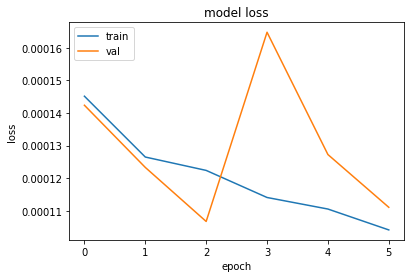

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test phase

273/273 [==============================] - 1s 3ms/step
MAE (Temp_IN):  0.1283
RMSE (Temp_IN):  0.1738


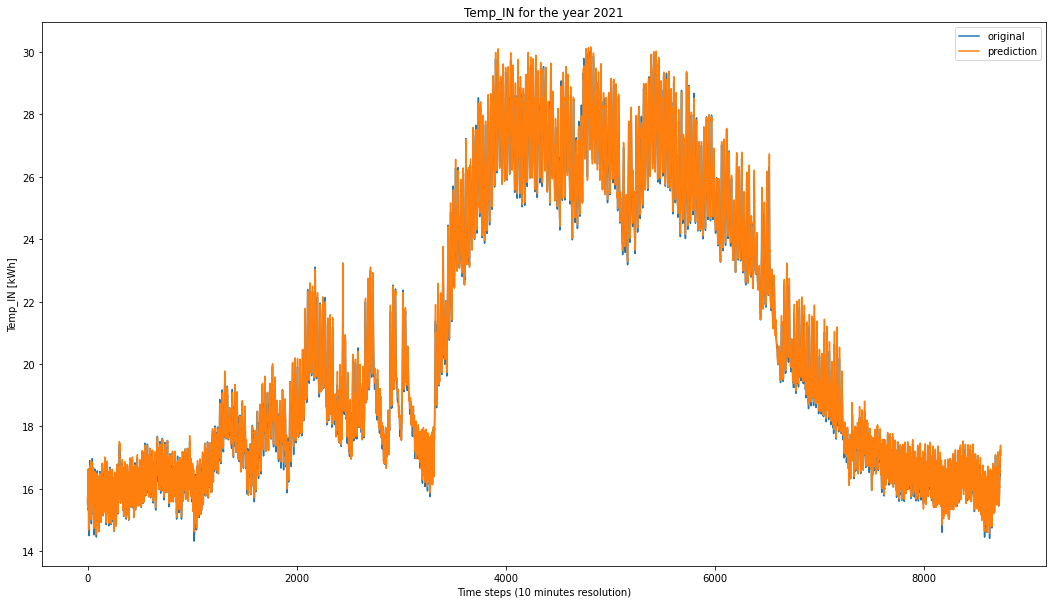

In [51]:
model.load_weights(f'{regressands[0].split(":")[0]}/{model_choice}.h5')
final_pred = {}

out = model.predict(testX)

for i, reg in enumerate(regressands):
    temp = out[:, :, i] * (y_train_max[i] - y_train_min[i]) + y_train_min[i]
    # temp = out[:, :, i] * y_train_std[i]
    final_pred[reg] = temp.reshape((testX.shape[0]*next_hours))
    err = (abs(X_test.values[past_hours
                             :past_hours
                              +len(final_pred[reg]), -len(regressands)+i]-final_pred[reg])).mean()
    rmse = math.sqrt(((X_test.values[past_hours
                                     :past_hours
                                      +len(final_pred[reg]), -len(regressands)+i]-final_pred[reg])**2).mean())
    print(f'MAE ({regressands[0].split(":")[0]}): ', round(err, 4))
    print(f'RMSE ({regressands[0].split(":")[0]}): ', round(rmse, 4))

    fig = plt.figure(figsize=(18,10))
    plt.title(reg)
    plt.plot(X_test.values[past_hours
                           :past_hours
                            +len(final_pred[reg]), 5+len(features)+i], label='original')
    plt.plot(final_pred[reg], label=f'prediction')
    plt.ylabel(f'{regressands[0].split(":")[0]} [kWh]')
    plt.xlabel('Time steps (10 minutes resolution)')
    plt.title(f'{regressands[0].split(":")[0]} for the year 2021')
    plt.legend()
    plt.show()

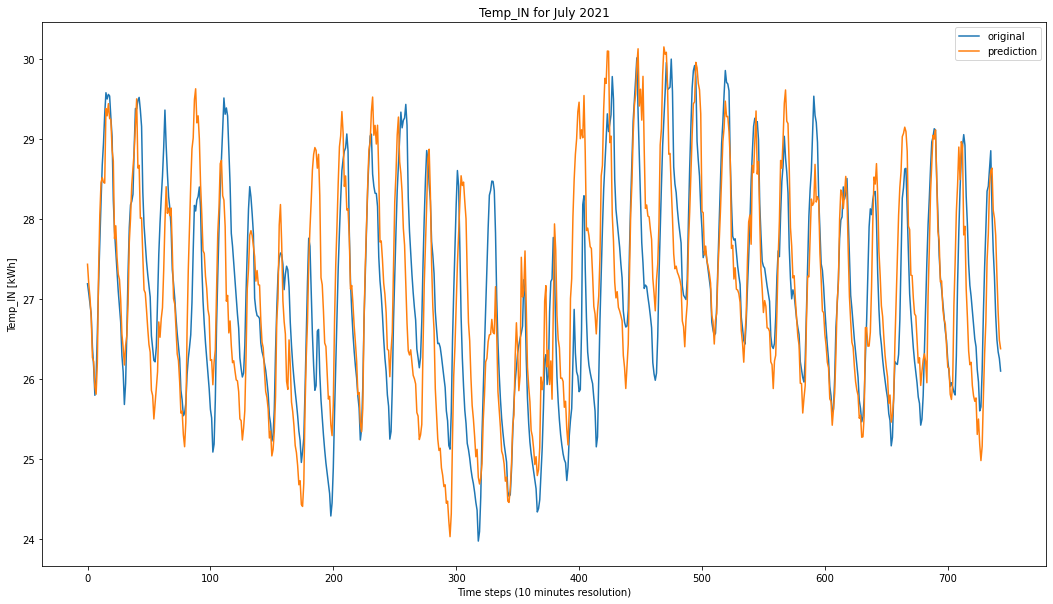

In [52]:
for i, reg in enumerate(regressands):
    fig = plt.figure(figsize=(18,10))
    plt.title(reg)
    plt.plot(X_test.values[24*181:24*212, 5+len(features)+i], label='original')
    plt.plot(final_pred[reg][24*181:24*212], label=f'prediction')
    plt.ylabel(f'{regressands[0].split(":")[0]} [kWh]')
    plt.xlabel('Time steps (10 minutes resolution)')
    plt.title(f'{regressands[0].split(":")[0]} for July 2021')
    plt.legend()
    plt.show()

past_hours


In [82]:
# Loading the dataset and splitting it into train and test subsets
days = []
months = []
hours = []
years = []
minutes = []
for timestamp in df_train['Date/Time']:
    days.append(timestamp.day)
    months.append(timestamp.month)
    hours.append(timestamp.hour)
    years.append(timestamp.year)
    minutes.append(timestamp.minute)

X_train = pd.DataFrame()
X_train['day'] = days
X_train['month'] = months
X_train['year'] = years
X_train['hour'] = hours
X_train['minute'] = minutes

X_train.index = df_train.index
X_train = X_train.join(df_train[np.concatenate((features, regressands))])

X_train = X_train.astype('float32')
normalized_X_train=(X_train-X_train.min())/(X_train.max()-X_train.min())
normalized_X_train.dropna(axis=1, inplace=True)
y_train_min, y_train_max = X_train[regressands].min(), X_train[regressands].max()
y_train_mean, y_train_std = X_train[regressands].mean(), X_train[regressands].std()

# Loading the test dataset
days = []
months = []
years = []
hours = []
minutes = []
for timestamp in df_test['Date/Time']:
    days.append(timestamp.day)
    months.append(timestamp.month)
    years.append(timestamp.year)
    hours.append(timestamp.hour)
    minutes.append(timestamp.minute)

X_test = pd.DataFrame()
X_test['day'] = days
X_test['month'] = months
X_test['year'] = years
X_test['hour'] = hours
X_test['minute'] = minutes
X_test.index = df_test.index
X_test = X_test.join(df_test[np.concatenate((features, regressands))])

X_test = X_test.astype('float32')
normalized_X_test=(X_test-X_train.min())/(X_train.max()-X_train.min())
normalized_X_test.dropna(axis=1, inplace=True)
#normalized_X_test=(X_test-X_test.min())/(X_test.max()-X_test.min())
y_test_min, y_test_max = X_test[regressands].min(), X_test[regressands].max()

In [86]:
sizes = np.array([6, 12, 24, 48, 72, 96, 120, 144, 168])
mae_values = {}
#pred_values = {}
#real_values = {}
rmse_values = {}
for i in sizes:
    past_hours\
        = i
    next_hours = 1
    print(f'past_hours'
          f': {past_hours
    }')
    print(f'next_hours: {next_hours}')
    trainX, trainY = [], []
    for j in range(past_hours
            , len(normalized_X_train.index)-next_hours, 1):
        input, val = normalized_X_train.values[j-past_hours
                                               :j, :], normalized_X_train.values[j:j+next_hours,-len(regressands):]  # I know that regressands are the last columns
        trainX.append(input)
        trainY.append(val)

    #val_size = round(len(trainX)*0.25)
    val_size = 24*60  # 2 months
    valX = []
    valY = []
    for v in range(val_size):
        rand_i = random.choice(range(len(trainX)))
        valX.append(trainX.pop(rand_i))
        valY.append(trainY.pop(rand_i))

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    valX = np.array(valX)
    valY = np.array(valY)
    print(f'trainX shape: {trainX.shape}')
    print(f'trainY shape: {trainY.shape}')
    print(f'valX shape: {valX.shape}')
    print(f'valY shape: {valY.shape}')

    testX = []
    for t in range(past_hours
            , len(normalized_X_test.index)-next_hours, next_hours):
        testX.append(normalized_X_test.values[t-past_hours
                                              :t, :])
    testX = np.array(testX)
    print(f'testX shape: {testX.shape}')
    print("")
    # Model
    model = Sequential()
    model.add(Reshape((past_hours
                       , normalized_X_train.shape[1], 1), input_shape=(past_hours
                                                                                             , normalized_X_train.shape[1])))
    model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
    model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dense(32))
    model.add(Dense(next_hours*len(regressands)))
    model.add(ReLU())
    model.add(Reshape((next_hours, len(regressands))))
    #
    #lr_schedule = ExponentialDecay(initial_learning_rate=0.2, decay_steps=1000, decay_rate=0.9, staircase=False)  # 0.0053 17/30
    #opt = Adagrad(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer='adam', metrics='mean_absolute_error')
    # print(model.summary())

    es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
    mc = ModelCheckpoint(f'{regressands[0].split(":")[0]}/{i}H_forecast.h5', monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

    print(f'Forecasting {i}H ahead...')
    try:
        model.load_weights(f'{regressands[0].split(":")[0]}/{i}H_forecast.h5')
        print('Already trained model found!')
    except:
        history = model.fit(x=trainX, y=trainY, batch_size=10, epochs=30, shuffle=True, validation_data=(valX, valY), callbacks=[es, mc])
    print('\n-------------------------- ----\n')

    model.load_weights(f'{regressands[0].split(":")[0]}/{i}H_forecast.h5')

    final_pred = model.predict(testX)[:,:,0]*(y_train_max.iloc[0]-y_train_min.iloc[0])+y_train_min.iloc[0]

    final_pred = final_pred.reshape((testX.shape[0]*next_hours))

    mae = (abs(X_test.values[past_hours
                             :past_hours
                              +len(final_pred), -1]-final_pred)).mean()
    rmse = math.sqrt(((X_test.values[past_hours
                                     :past_hours
                                      +len(final_pred), -1]-final_pred)**2).mean())

    mae_values[f'{i}H'] = [mae]
    rmse_values[f'{i}H'] = [rmse]
    #pred_values[f'{i//6}H'] = final_pred[:(len(X_test)-past_hours
    # )]
    #real_values[f'{i//6}H'] = X_test.values[past_hours
    # :, -1]

window: 6
forseen: 1
trainX shape: (24833, 6, 6)
trainY shape: (24833, 1, 1)
valX shape: (1440, 6, 6)
valY shape: (1440, 1, 1)
testX shape: (8753, 6, 6)

Forecasting 6H ahead...
Epoch 1/30
2484/2484 [==============================] - 20s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0242 - val_loss: 3.6336e-04 - val_mean_absolute_error: 0.0152
Epoch 2/30
2484/2484 [==============================] - 18s 7ms/step - loss: 4.1076e-04 - mean_absolute_error: 0.0155 - val_loss: 4.1830e-04 - val_mean_absolute_error: 0.0166
Epoch 3/30
2484/2484 [==============================] - 18s 7ms/step - loss: 3.4479e-04 - mean_absolute_error: 0.0142 - val_loss: 3.6936e-04 - val_mean_absolute_error: 0.0152
Epoch 4/30
2484/2484 [==============================] - 22s 9ms/step - loss: 3.0142e-04 - mean_absolute_error: 0.0132 - val_loss: 2.8030e-04 - val_mean_absolute_error: 0.0128
Epoch 5/30
2484/2484 [==============================] - 20s 8ms/step - loss: 2.6870e-04 - mean_absolute_error: 0.0125 - val_lo

Plots

In [87]:
pred_x = [x for x in sizes]
pred_y_rmse = []
pred_y_mae = []
print( mae_values.keys())
for k in mae_values.keys():
    print(f'k {k} mae_values.keys {mae_values.keys}')
    pred_y_rmse.append(rmse_values[k][0])
    pred_y_mae.append(mae_values[k][0])

errors_df = pd.DataFrame({'past_hours'
                          ' [hours]': pred_x, 'MAE': pred_y_mae, 'RMSE': pred_y_rmse})
errors_df.to_csv(f'{regressands[0].split(":")[0]}/errors.csv', index=False)

dict_keys(['6H', '12H', '24H', '48H', '72H', '96H', '120H', '144H', '168H'])
k 6H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 12H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 24H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 48H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 72H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 96H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 120H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 144H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 168H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>


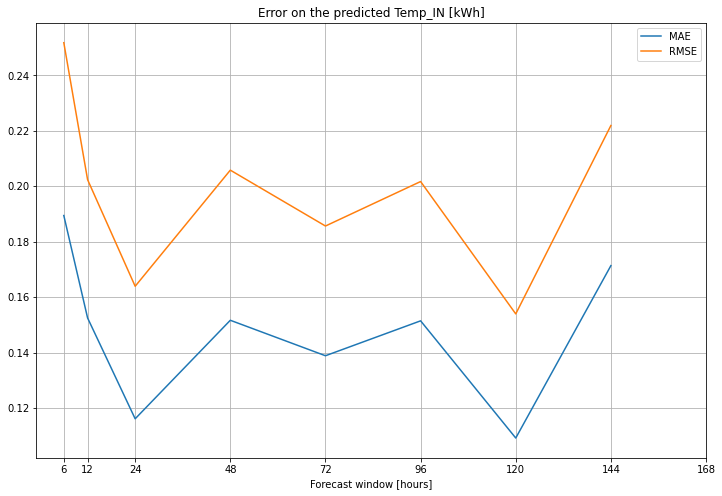

In [90]:
plt.figure(figsize=(12,8))
plt.plot(pred_x[0:-1], pred_y_mae[0:-1], label='MAE')
plt.plot(pred_x[0:-1], pred_y_rmse[0:-1], label='RMSE')
plt.xlabel('Forecast past_hours'
           ' [hours]')
plt.title(f'Error on the predicted {regressands[0].split(":")[0]} [kWh]')
plt.xticks(pred_x)
plt.grid()
plt.savefig(f'{regressands[0].split(":")[0]}/errors_plot')
plt.legend()